## Jupyter notebook para processamento no container jupyter-spark

In [1]:
# Ler arquivos CSV do HDFS

read_files = spark.read.csv("hdfs://namenode:8020/user/anderson/data/covid/bases", sep=";", header="true")

In [2]:
# Verificar schema

read_files.printSchema()

root
 |-- regiao: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- coduf: string (nullable = true)
 |-- codmun: string (nullable = true)
 |-- codRegiaoSaude: string (nullable = true)
 |-- nomeRegiaoSaude: string (nullable = true)
 |-- data: string (nullable = true)
 |-- semanaEpi: string (nullable = true)
 |-- populacaoTCU2019: string (nullable = true)
 |-- casosAcumulado: string (nullable = true)
 |-- casosNovos: string (nullable = true)
 |-- obitosAcumulado: string (nullable = true)
 |-- obitosNovos: string (nullable = true)
 |-- Recuperadosnovos: string (nullable = true)
 |-- emAcompanhamentoNovos: string (nullable = true)
 |-- interior/metropolitana: string (nullable = true)



In [3]:
# Definir schema alterando o tipo dos valores numéricos de String para Integer

from pyspark.sql.types import StructType, StructField, StringType, IntegerType

covid_schema = (StructType([
      StructField("regiao", StringType()),
      StructField("estado", StringType()),
      StructField("municipio", StringType()),
      StructField("coduf", StringType()),
      StructField("codmun", StringType()),
      StructField("codRegiaoSaude", StringType()),
      StructField("nomeRegiaoSaude", StringType()),
      StructField("data", StringType()),
      StructField("semanaEpi", StringType()),
      StructField("populacaoTCU2019", IntegerType()),
      StructField("casosAcumulado", IntegerType()),
      StructField("casosNovos", IntegerType()),
      StructField("obitosAcumulado", IntegerType()),
      StructField("obitosNovos", IntegerType()),
      StructField("Recuperadosnovos", IntegerType()),
      StructField("emAcompanhamentoNovos", IntegerType()),
      StructField("interior/metropolitana", StringType()),
    ]))


leitura_arquivos = spark.read.schema(covid_schema).csv('/user/anderson/data/covid/bases/', sep=";", header="true")

In [4]:
# Ler esquema

leitura_arquivos.printSchema()

root
 |-- regiao: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- coduf: string (nullable = true)
 |-- codmun: string (nullable = true)
 |-- codRegiaoSaude: string (nullable = true)
 |-- nomeRegiaoSaude: string (nullable = true)
 |-- data: string (nullable = true)
 |-- semanaEpi: string (nullable = true)
 |-- populacaoTCU2019: integer (nullable = true)
 |-- casosAcumulado: integer (nullable = true)
 |-- casosNovos: integer (nullable = true)
 |-- obitosAcumulado: integer (nullable = true)
 |-- obitosNovos: integer (nullable = true)
 |-- Recuperadosnovos: integer (nullable = true)
 |-- emAcompanhamentoNovos: integer (nullable = true)
 |-- interior/metropolitana: string (nullable = true)



In [6]:
# 2. Otimizar todos os dados do hdfs para uma tabela Hive particionada por município.

leitura_arquivos.write.partitionBy("municipio").saveAsTable('tb_covid')

dados_covid = spark.read.table("tb_covid")

dados_covid.count()

2624943

In [8]:
spark.read.table("tb_covid").printSchema()

root
 |-- regiao: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- coduf: string (nullable = true)
 |-- codmun: string (nullable = true)
 |-- codRegiaoSaude: string (nullable = true)
 |-- nomeRegiaoSaude: string (nullable = true)
 |-- data: string (nullable = true)
 |-- semanaEpi: string (nullable = true)
 |-- populacaoTCU2019: integer (nullable = true)
 |-- casosAcumulado: integer (nullable = true)
 |-- casosNovos: integer (nullable = true)
 |-- obitosAcumulado: integer (nullable = true)
 |-- obitosNovos: integer (nullable = true)
 |-- Recuperadosnovos: integer (nullable = true)
 |-- emAcompanhamentoNovos: integer (nullable = true)
 |-- interior/metropolitana: string (nullable = true)
 |-- municipio: string (nullable = true)



In [9]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [10]:
table = spark.read.table("tb_covid")

In [11]:
# 3. Criar as 3 vizualizações pelo Spark com os dados enviados para o HDFS:

In [12]:
visualizacao_1 = table.groupBy("regiao","data") \
        .agg(sum("Recuperadosnovos").alias("Casos_Recuperados"), \
             sum("emAcompanhamentoNovos").alias("Casos_Em_Acompanhamento") \
            ).sort(desc("data"))

In [13]:
visualizacao_1

DataFrame[regiao: string, data: string, Casos_Recuperados: bigint, Casos_Em_Acompanhamento: bigint]

In [14]:
visualizacao_1.show(6)

+------------+----------+-----------------+-----------------------+
|      regiao|      data|Casos_Recuperados|Casos_Em_Acompanhamento|
+------------+----------+-----------------+-----------------------+
|Centro-Oeste|2021-07-06|             null|                   null|
|       Norte|2021-07-06|             null|                   null|
|     Sudeste|2021-07-06|             null|                   null|
|    Nordeste|2021-07-06|             null|                   null|
|         Sul|2021-07-06|             null|                   null|
|      Brasil|2021-07-06|         17262646|                1065477|
+------------+----------+-----------------+-----------------------+
only showing top 6 rows



In [15]:
visualizacao_2 = table.groupBy("regiao","data")\
        .agg(sum("casosAcumulado").alias("Casos_Acumulados"),\
             sum("casosNovos").alias("Casos_Novos"),\
             sum("populacaoTCU2019").alias("Populacao")
            ).sort(desc("data"))

In [16]:
visualizacao_2.show(6)

+------------+----------+----------------+-----------+---------+
|      regiao|      data|Casos_Acumulados|Casos_Novos|Populacao|
+------------+----------+----------------+-----------+---------+
|    Nordeste|2021-07-06|         8911474|      23290|114143308|
|       Norte|2021-07-06|         3465630|       5244| 36861960|
|     Sudeste|2021-07-06|        14277606|      62182|176742866|
|         Sul|2021-07-06|         7222082|      22800| 59951968|
|Centro-Oeste|2021-07-06|         3833238|      11492| 32594148|
|      Brasil|2021-07-06|        18855015|      62504|210147125|
+------------+----------+----------------+-----------+---------+
only showing top 6 rows



In [17]:
visualizacao_2.columns

['regiao', 'data', 'Casos_Acumulados', 'Casos_Novos', 'Populacao']

In [18]:
visualizacao_2 = visualizacao_2.withColumn("Incidencia",100000*col('Casos_Acumulados')/col('Populacao'))

In [20]:
visualizacao_2 = visualizacao_2.drop("Populacao")

In [21]:
visualizacao_2.show(6)

+------------+----------+----------------+-----------+------------------+
|      regiao|      data|Casos_Acumulados|Casos_Novos|        Incidencia|
+------------+----------+----------------+-----------+------------------+
|       Norte|2021-07-06|         3465630|       5244| 9401.643320105604|
|Centro-Oeste|2021-07-06|         3833238|      11492|11760.509892757436|
|    Nordeste|2021-07-06|         8911474|      23290| 7807.268035371815|
|         Sul|2021-07-06|         7222082|      22800|12046.446915637533|
|     Sudeste|2021-07-06|        14277606|      62182| 8078.179517582339|
|      Brasil|2021-07-06|        18855015|      62504| 8972.292625940041|
+------------+----------+----------------+-----------+------------------+
only showing top 6 rows



In [22]:
visualizacao_3 = table.groupBy("regiao","data") \
        .agg(sum("casosAcumulado").alias("Casos_Acumulados"), \
             sum("obitosAcumulado").alias("Obitos_Acumulados"), \
             sum("obitosNovos").alias("Obitos_Novos"),\
             sum("populacaoTCU2019").alias("Populacao")
            ).sort(desc("data"))

In [23]:
visualizacao_3.show(6)

+------------+----------+----------------+-----------------+------------+---------+
|      regiao|      data|Casos_Acumulados|Obitos_Acumulados|Obitos_Novos|Populacao|
+------------+----------+----------------+-----------------+------------+---------+
|Centro-Oeste|2021-07-06|         3833238|            98414|         302| 32594148|
|       Norte|2021-07-06|         3465630|            87690|         138| 36861960|
|     Sudeste|2021-07-06|        14277606|           490622|        1842|176742866|
|    Nordeste|2021-07-06|         8911474|           215648|         576|114143308|
|         Sul|2021-07-06|         7222082|           161410|         702| 59951968|
|      Brasil|2021-07-06|        18855015|           526892|        1780|210147125|
+------------+----------+----------------+-----------------+------------+---------+
only showing top 6 rows



In [24]:
visualizacao_3 = visualizacao_3.withColumn("Letalidade", format_number(100*col('Obitos_Acumulados')/col('Casos_Acumulados'),2))
visualizacao_3 = visualizacao_3.withColumn("Mortalidade", format_number(100000*col('Obitos_Acumulados')/col('populacao'),2))

In [27]:
visualizacao_3 = visualizacao_3.drop("Populacao")
visualizacao_3 = visualizacao_3.drop("Casos_Acumulados")

In [28]:
visualizacao_3.show(6)

+------------+----------+-----------------+------------+----------+-----------+
|      regiao|      data|Obitos_Acumulados|Obitos_Novos|Letalidade|Mortalidade|
+------------+----------+-----------------+------------+----------+-----------+
|Centro-Oeste|2021-07-06|            98414|         302|      2.57|     301.94|
|       Norte|2021-07-06|            87690|         138|      2.53|     237.89|
|     Sudeste|2021-07-06|           490622|        1842|      3.44|     277.59|
|         Sul|2021-07-06|           161410|         702|      2.23|     269.23|
|    Nordeste|2021-07-06|           215648|         576|      2.42|     188.93|
|      Brasil|2021-07-06|           526892|        1780|      2.79|     250.73|
+------------+----------+-----------------+------------+----------+-----------+
only showing top 6 rows



In [31]:
# 4. Salvar a primeira visualização como tabela Hive

visualizacao_1.write.saveAsTable('tb_casos_recuperados')

In [32]:
!hdfs dfs -ls /user/hive/warehouse

Found 3 items
drwxr-xr-x   - root supergroup          0 2021-10-20 17:01 /user/hive/warehouse/juros
drwxr-xr-x   - root supergroup          0 2021-11-10 00:46 /user/hive/warehouse/tb_casos_recuperados
drwxr-xr-x   - root supergroup          0 2021-11-10 00:01 /user/hive/warehouse/tb_covid


In [33]:
# 5. Salvar a segunda visualização com formato parquet e compressão snappy

visualizacao_2.write.saveAsTable("tb_casos_confirmados", compression='snappy')

In [34]:
!hdfs dfs -ls /user/hive/warehouse/tb_casos_confirmados

Found 201 items
-rw-r--r--   2 root supergroup          0 2021-11-10 00:47 /user/hive/warehouse/tb_casos_confirmados/_SUCCESS
-rw-r--r--   2 root supergroup       1869 2021-11-10 00:47 /user/hive/warehouse/tb_casos_confirmados/part-00000-223d388a-c652-46c4-8f9f-6c5e3cca5cae-c000.snappy.parquet
-rw-r--r--   2 root supergroup       1745 2021-11-10 00:47 /user/hive/warehouse/tb_casos_confirmados/part-00001-223d388a-c652-46c4-8f9f-6c5e3cca5cae-c000.snappy.parquet
-rw-r--r--   2 root supergroup       1868 2021-11-10 00:47 /user/hive/warehouse/tb_casos_confirmados/part-00002-223d388a-c652-46c4-8f9f-6c5e3cca5cae-c000.snappy.parquet
-rw-r--r--   2 root supergroup       1737 2021-11-10 00:47 /user/hive/warehouse/tb_casos_confirmados/part-00003-223d388a-c652-46c4-8f9f-6c5e3cca5cae-c000.snappy.parquet
-rw-r--r--   2 root supergroup       1876 2021-11-10 00:47 /user/hive/warehouse/tb_casos_confirmados/part-00004-223d388a-c652-46c4-8f9f-6c5e3cca5cae-c000.snappy.parquet
-rw-r--r--   2 root supergrou

In [58]:
visualizacao_kafka = visualizacao_3.select("regiao","data","Obitos_Acumulados","Obitos_Novos","Letalidade","Mortalidade")

In [59]:
visualizacao_kafka.show(6)

+------------+----------+-----------------+------------+----------+-----------+
|      regiao|      data|Obitos_Acumulados|Obitos_Novos|Letalidade|Mortalidade|
+------------+----------+-----------------+------------+----------+-----------+
|Centro-Oeste|2021-07-06|            98414|         302|      2.57|     301.94|
|       Norte|2021-07-06|            87690|         138|      2.53|     237.89|
|    Nordeste|2021-07-06|           215648|         576|      2.42|     188.93|
|         Sul|2021-07-06|           161410|         702|      2.23|     269.23|
|     Sudeste|2021-07-06|           490622|        1842|      3.44|     277.59|
|      Brasil|2021-07-06|           526892|        1780|      2.79|     250.73|
+------------+----------+-----------------+------------+----------+-----------+
only showing top 6 rows



In [66]:
dados_kafka = visualizacao_kafka.select("regiao","data","Obitos_Acumulados","Obitos_Novos","Letalidade","Mortalidade") \
                                .withColumnRenamed("Obitos_Acumulados","value") \
                                .withColumn("value",col("value").cast(StringType()))

In [67]:
dados_kafka.show(6)

+------------+----------+------+------------+----------+-----------+
|      regiao|      data| value|Obitos_Novos|Letalidade|Mortalidade|
+------------+----------+------+------------+----------+-----------+
|    Nordeste|2021-07-06|215648|         576|      2.42|     188.93|
|       Norte|2021-07-06| 87690|         138|      2.53|     237.89|
|         Sul|2021-07-06|161410|         702|      2.23|     269.23|
|     Sudeste|2021-07-06|490622|        1842|      3.44|     277.59|
|Centro-Oeste|2021-07-06| 98414|         302|      2.57|     301.94|
|      Brasil|2021-07-06|526892|        1780|      2.79|     250.73|
+------------+----------+------+------------+----------+-----------+
only showing top 6 rows



In [68]:
dados_kafka.printSchema()

root
 |-- regiao: string (nullable = true)
 |-- data: string (nullable = true)
 |-- value: string (nullable = true)
 |-- Obitos_Novos: long (nullable = true)
 |-- Letalidade: string (nullable = true)
 |-- Mortalidade: string (nullable = true)



In [69]:
# 6. Salvar a terceira visualização em um tópico no Kafka

dados_kafka.write.format('kafka') \
              .option("kafka.bootstrap.servers","kafka:9092") \
              .option("topic","topic-vis-3") \
              .save()

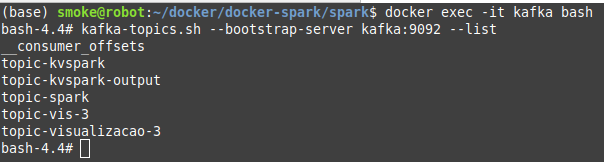

In [74]:
from IPython.display import Image
Image(filename='kafka.png')

In [77]:
# 7. Criar a visualização pelo Spark com os dados enviados para o HDFS

visualizacao_hdfs = table.groupBy("regiao")\
        .agg(sum("casosAcumulado").alias("Casos"),\
             sum("obitosAcumulado").alias("Obitos"),\
             sum("populacaoTCU2019").alias("Populacao"),\
            ).sort(desc("Casos"))

visualizacao_hdfs = visualizacao_hdfs.withColumn("Incidencia/100mil hab.",format_number(100000*col('Casos')/col('Populacao'),2))
visualizacao_hdfs = visualizacao_hdfs.withColumn("Mortalidade/100mil hab.", format_number(100000*col('Obitos')/col('Populacao'),2))
visualizacao_hdfs = visualizacao_hdfs.drop("Populacao")

In [78]:
visualizacao_hdfs.show(6)

+------------+----------+--------+----------------------+-----------------------+
|      regiao|     Casos|  Obitos|Incidencia/100mil hab.|Mortalidade/100mil hab.|
+------------+----------+--------+----------------------+-----------------------+
|      Brasil|3343282900|91858674|              3,181.85|                  87.42|
|     Sudeste|2416910626|83614760|              2,834.14|                  98.05|
|    Nordeste|1634815853|42382977|              2,968.57|                  76.96|
|         Sul|1151576475|22680051|              3,981.00|                  78.40|
|       Norte| 736423753|18126551|              4,140.63|                 101.92|
|Centro-Oeste| 715162485|16114579|              4,547.45|                 102.47|
+------------+----------+--------+----------------------+-----------------------+
only showing top 6 rows



In [79]:
# 8. Salvar a visualização do exercício 6 em um tópico no Elastic

topic_elastic = dados_kafka

In [80]:
topic_elastic.show(5)

+------------+----------+------+------------+----------+-----------+
|      regiao|      data| value|Obitos_Novos|Letalidade|Mortalidade|
+------------+----------+------+------------+----------+-----------+
|       Norte|2021-07-06| 87690|         138|      2.53|     237.89|
|    Nordeste|2021-07-06|215648|         576|      2.42|     188.93|
|Centro-Oeste|2021-07-06| 98414|         302|      2.57|     301.94|
|     Sudeste|2021-07-06|490622|        1842|      3.44|     277.59|
|         Sul|2021-07-06|161410|         702|      2.23|     269.23|
+------------+----------+------+------------+----------+-----------+
only showing top 5 rows



In [81]:
topic_elastic.write.csv("/user/hive/warehouse/topic-vis-3")

In [82]:
!hdfs dfs -ls /user/hive/warehouse/topic-vis-3

Found 201 items
-rw-r--r--   2 root supergroup          0 2021-11-10 01:34 /user/hive/warehouse/topic-vis-3/_SUCCESS
-rw-r--r--   2 root supergroup        748 2021-11-10 01:34 /user/hive/warehouse/topic-vis-3/part-00000-6b31e412-319b-4cad-b4c2-cb638b329da1-c000.csv
-rw-r--r--   2 root supergroup        502 2021-11-10 01:34 /user/hive/warehouse/topic-vis-3/part-00001-6b31e412-319b-4cad-b4c2-cb638b329da1-c000.csv
-rw-r--r--   2 root supergroup        753 2021-11-10 01:34 /user/hive/warehouse/topic-vis-3/part-00002-6b31e412-319b-4cad-b4c2-cb638b329da1-c000.csv
-rw-r--r--   2 root supergroup        497 2021-11-10 01:34 /user/hive/warehouse/topic-vis-3/part-00003-6b31e412-319b-4cad-b4c2-cb638b329da1-c000.csv
-rw-r--r--   2 root supergroup        753 2021-11-10 01:34 /user/hive/warehouse/topic-vis-3/part-00004-6b31e412-319b-4cad-b4c2-cb638b329da1-c000.csv
-rw-r--r--   2 root supergroup        502 2021-11-10 01:34 /user/hive/warehouse/topic-vis-3/part-00005-6b31e412-319b-4cad-b4c2-cb638b329da

-rw-r--r--   2 root supergroup        744 2021-11-10 01:34 /user/hive/warehouse/topic-vis-3/part-00061-6b31e412-319b-4cad-b4c2-cb638b329da1-c000.csv
-rw-r--r--   2 root supergroup        489 2021-11-10 01:34 /user/hive/warehouse/topic-vis-3/part-00062-6b31e412-319b-4cad-b4c2-cb638b329da1-c000.csv
-rw-r--r--   2 root supergroup        744 2021-11-10 01:34 /user/hive/warehouse/topic-vis-3/part-00063-6b31e412-319b-4cad-b4c2-cb638b329da1-c000.csv
-rw-r--r--   2 root supergroup        495 2021-11-10 01:34 /user/hive/warehouse/topic-vis-3/part-00064-6b31e412-319b-4cad-b4c2-cb638b329da1-c000.csv
-rw-r--r--   2 root supergroup        739 2021-11-10 01:34 /user/hive/warehouse/topic-vis-3/part-00065-6b31e412-319b-4cad-b4c2-cb638b329da1-c000.csv
-rw-r--r--   2 root supergroup        496 2021-11-10 01:34 /user/hive/warehouse/topic-vis-3/part-00066-6b31e412-319b-4cad-b4c2-cb638b329da1-c000.csv
-rw-r--r--   2 root supergroup        738 2021-11-10 01:34 /user/hive/warehouse/topic-vis-3/part-00067-6b3

In [ ]:
# 9. Criar um dashboard no Elastic para visualização dos novos dados enviados

# Pendência:
# Como conectar o container jupyter-spark ao container do Elastic
# Os dados serão enviados do hdfs para o Elastic ou o Elastic vai consumir direto do HDFS?